In [1]:
import sys
sys.path.append('..')

import torch
from torch import optim

import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as functional
from torch.utils.data import DataLoader

import clip
import json

from src.utils.collate_fn_coco import collate_fn_coco
from src.models.boxclip import BOXCLIP
from src.models.transformer import *
from src.utils.get_model_and_data import get_model_and_data

from d2l import torch as d2l
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
parameters = {'device': device}
model, datasets = get_model_and_data(parameters)

checkpoint_path = "../checkpoint/07-27-00-39/checkpoint-epoch40.pth.tar"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])

loading annotations into memory...
Done (t=15.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
train set scale: 21391
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
val set scale: 925


<All keys matched successfully>

h, w in collate: 224, 224
h, w in collate: 224, 224
h, w in collate: 224, 224
h, w in collate: 224, 224
h, w in collate: 224, 224


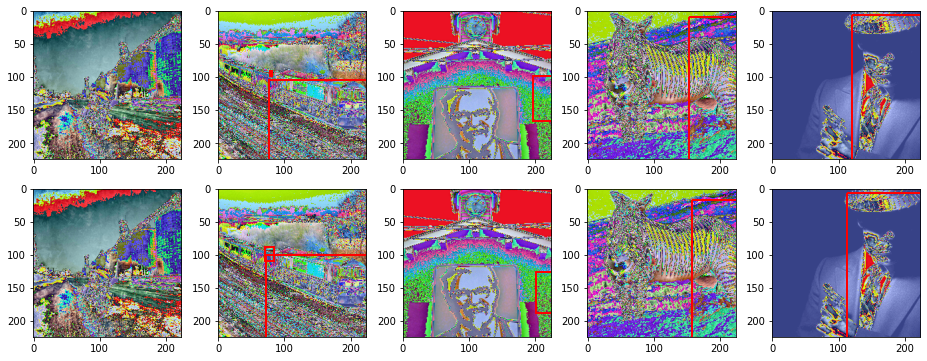

In [3]:
dataloader = torch.utils.data.DataLoader(datasets['train'], batch_size=5, shuffle=True, 
                                         collate_fn=collate_fn_coco)

num_img = 5
to_pil_image = transforms.ToPILImage()
plt.figure(figsize=(16, 6))

# model = BOXCLIP(encoder, decoder, categories=categories, device=device).to(device)
# model.load_state_dict(torch.load("./model/bbox-cats-10eps.pkl"))

model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = model(batch)
        for num_img in range(5):

            plt.subplot(2, 5, num_img+1)
            plt.imshow(to_pil_image(batch['clip_images'][num_img]))

            for bbox, cat_id in batch['bboxes'][num_img]:

                [bbox_x, bbox_y, bbox_w, bbox_h] = bbox
                w, h = 224, 224
    #             print(bbox_x, bbox_y, bbox_w, bbox_h)
                plt.gca().add_patch(plt.Rectangle((bbox_x*w, bbox_y*h), bbox_w*w, bbox_h*h, 
                                                  fill=False, edgecolor='r', linewidth=2))
#             plt.title('\n'.join([categories[cat_id] for _, cat_id in batch['bboxes'][num_img]]))

        for num_img in range(5):
            plt.subplot(2, 5, num_img+6)
            plt.imshow(to_pil_image(batch['clip_images'][num_img]))

    #         print(batch['output'].shape)
            for j in range(batch['output_bbox'][num_img].shape[0]):
                [bbox_x, bbox_y, bbox_w, bbox_h] = batch['output_bbox'][num_img][j].cpu()
#                 print(bbox_x, bbox_y, bbox_w, bbox_h)
                plt.gca().add_patch(plt.Rectangle((bbox_x*w, bbox_y*h), bbox_w*w, bbox_h*h, 
                                                  fill=False, edgecolor='r', linewidth=2))
            pred_cat = []
#             for i in range(batch['output_cat'][num_img].shape[0]):
#                 print(batch['output_cat'][num_img][i].item())
#                 pred_cat.append(categories[batch['output_cat'][num_img][i].item()])
#             plt.title('\n'.join(pred_cat))
#         print(batch['output_cat'])

        break